<div>
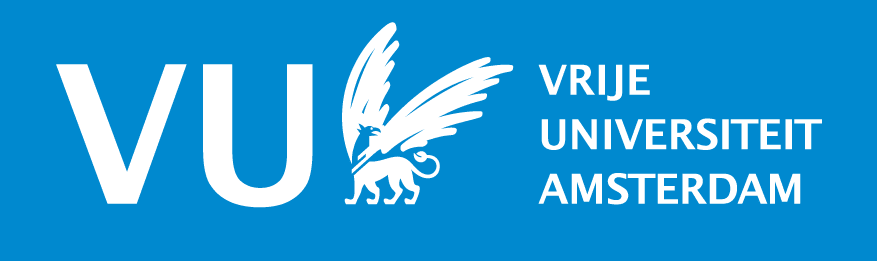
</div>

### Gridap day at "Groupe Calcul"

# Lazy evaluation in Gridap

by Francesc Verdugo (VU Amsterdam)

2022-12-01

## Contents

In this tutorial, we will learn:

  - How Gridap leverages "lazy evaluation"
  - How to manipulate mesh data without foor-loops
  - How to load meshes generted with Gmsh
  - How to export data in vtu format

## Example

Evaluate function $f(x,y)=\sin(5 x)\cos(10 y)$ at the mid points of the cells in a mesh

- Do it without writing for loops
- (in an efficient way)




<div>
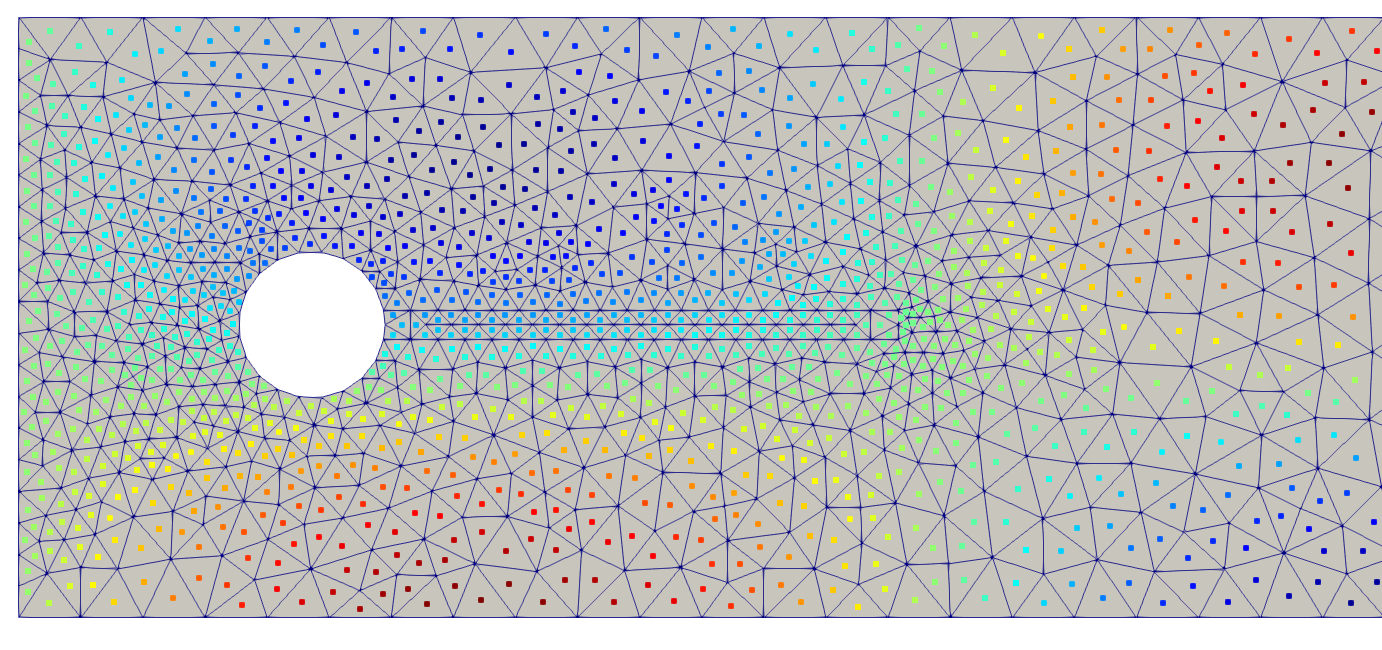
</div>



## Bonus example

Evaluate function $f(x,y)=\sin(5 x)\cos(10 y)$ at the mid points of the boundary faces



<div>
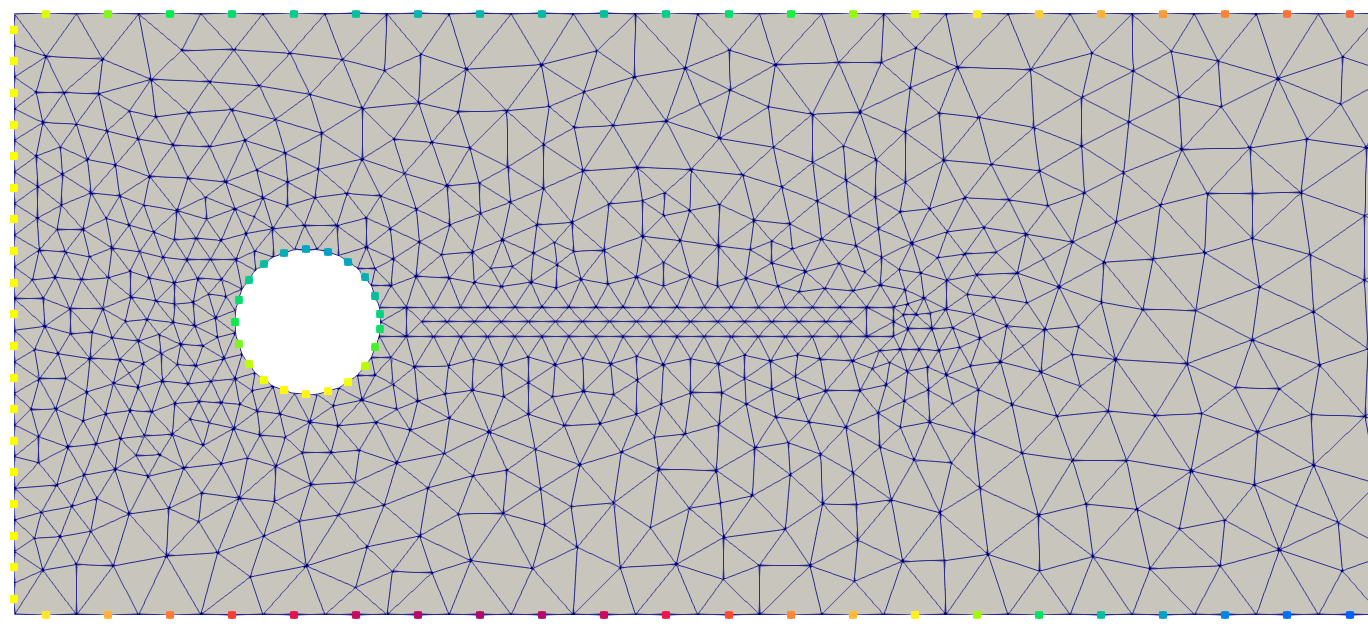
</div>


## Read a mesh from Gmsh

In [1]:
using Gridap
using GridapGmsh

In [2]:
msh_file = joinpath(@__DIR__,"elasticFlag.msh")
model = GmshDiscreteModel(msh_file);

Info    : Reading '/home/fverdugo/Code/jl/GridapDayAtInria2022/notebooks/lazy_evaluation/elasticFlag.msh'...
Info    : 21 entities
Info    : 1199 nodes
Info    : 2447 elements
Info    : Done reading '/home/fverdugo/Code/jl/GridapDayAtInria2022/notebooks/lazy_evaluation/elasticFlag.msh'


## Export the mesh in vtk

In [3]:
writevtk(model,"model")

3-element Vector{Vector{String}}:
 ["model_0.vtu"]
 ["model_1.vtu"]
 ["model_2.vtu"]


<div>
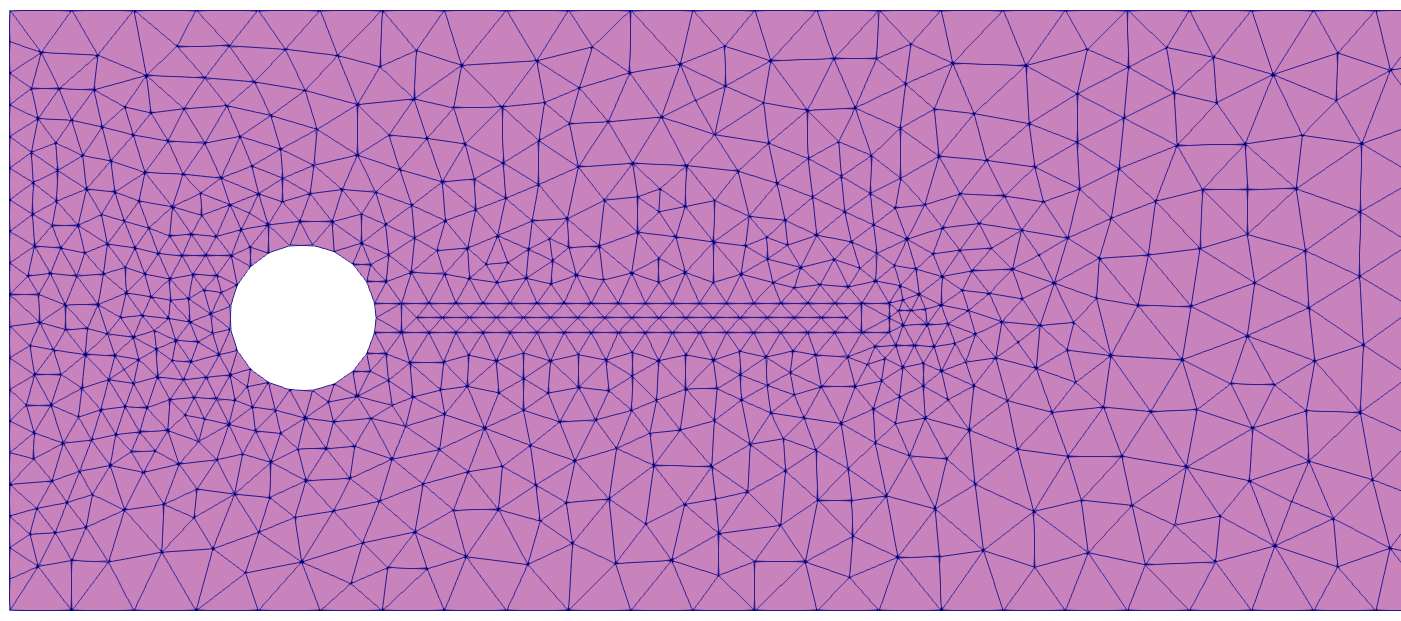
</div>


## Computational domains

In [4]:
Ω = Interior(model);

In [5]:
writevtk(Ω,"Ω")

(["Ω.vtu"],)

In [6]:
Γ = Boundary(model);

In [7]:
writevtk(Γ,"Γ")

(["Γ.vtu"],)

<div>
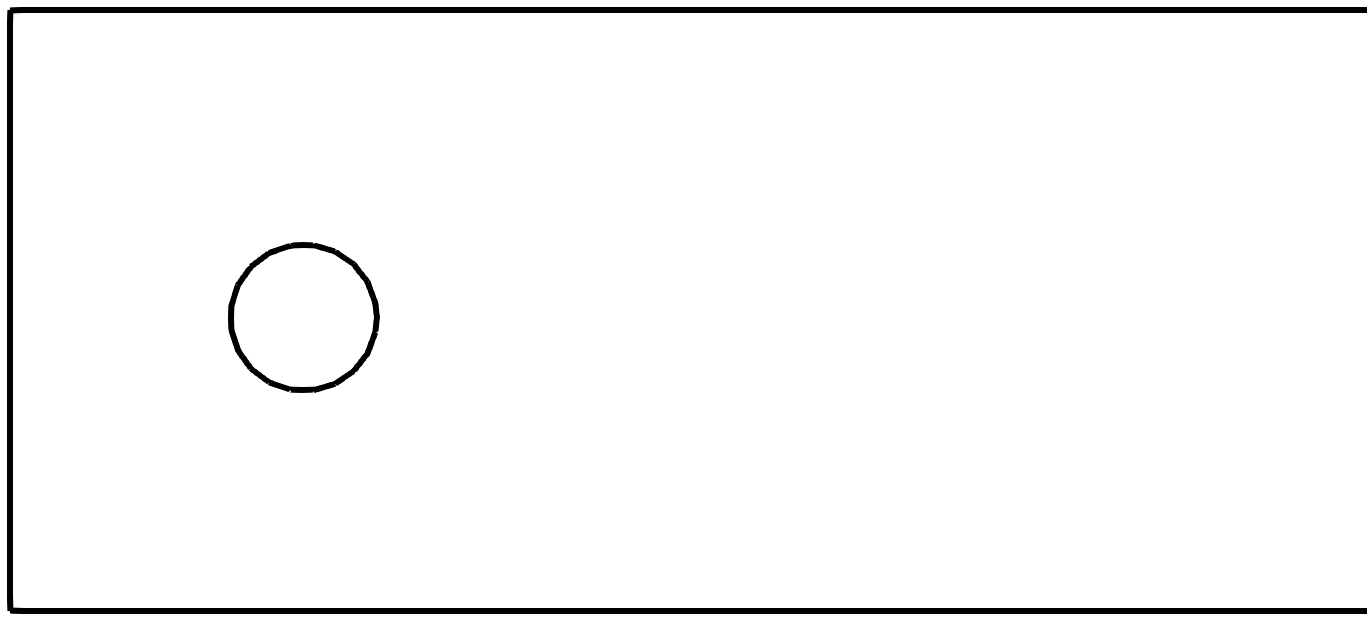
</div>


## Cell-wise nodal coordinates

In [8]:
cell_coords = get_cell_coordinates(Ω)
isa(cell_coords,AbstractArray)

true

In [9]:
length(cell_coords) == num_cells(Ω)

true

In [10]:
cell = 54
cell_coords[cell]

3-element Vector{VectorValue{2, Float64}}:
 VectorValue{2, Float64}(0.8430301334715491, 0.3185728103697778)
   VectorValue{2, Float64}(0.796578024428902, 0.317555926391821)
 VectorValue{2, Float64}(0.8235359999039109, 0.3466337302836475)

## Cell barycenter (for all cells)

In [11]:
midpoint(xs) = sum(xs)/length(xs)

midpoint (generic function with 1 method)

In [12]:
points = [Point(0,0),Point(1,1)]
midpoint(points)

VectorValue{2, Float64}(0.5, 0.5)

In [13]:
cell_barycenter = map(midpoint,cell_coords)

2231-element Vector{VectorValue{2, Float64}}:
  VectorValue{2, Float64}(2.4691562013666446, 0.12788585605226846)
  VectorValue{2, Float64}(0.06435077593824423, 0.2935676272218209)
 VectorValue{2, Float64}(0.06058912739891268, 0.24148766326947033)
  VectorValue{2, Float64}(0.8941356150061562, 0.31039767718351624)
   VectorValue{2, Float64}(0.9073059625811983, 0.2930473703989216)
  VectorValue{2, Float64}(0.4587049783324977, 0.10702681248478481)
 VectorValue{2, Float64}(0.12858025736877576, 0.10625764015090262)
  VectorValue{2, Float64}(0.4438237152393185, 0.31540220417400827)
  VectorValue{2, Float64}(0.5454233443792674, 0.16330364760504346)
   VectorValue{2, Float64}(1.2391153531725319, 0.2866283301955632)
  VectorValue{2, Float64}(1.2599943419408717, 0.28662833019556316)
 VectorValue{2, Float64}(0.21597883704332613, 0.25342146554443407)
   VectorValue{2, Float64}(1.647699964820233, 0.16800756789025292)
                                          ⋮
  VectorValue{2, Float64}(0.50762889338

In [14]:
length(cell_barycenter) == num_cells(Ω)

true

In [15]:
cell = 54
cell_barycenter[cell]

VectorValue{2, Float64}(0.8210480526014541, 0.3275874890150821)

In [16]:
writevtk(cell_barycenter,"barycenters")

(["barycenters.vtu"],)

<div>
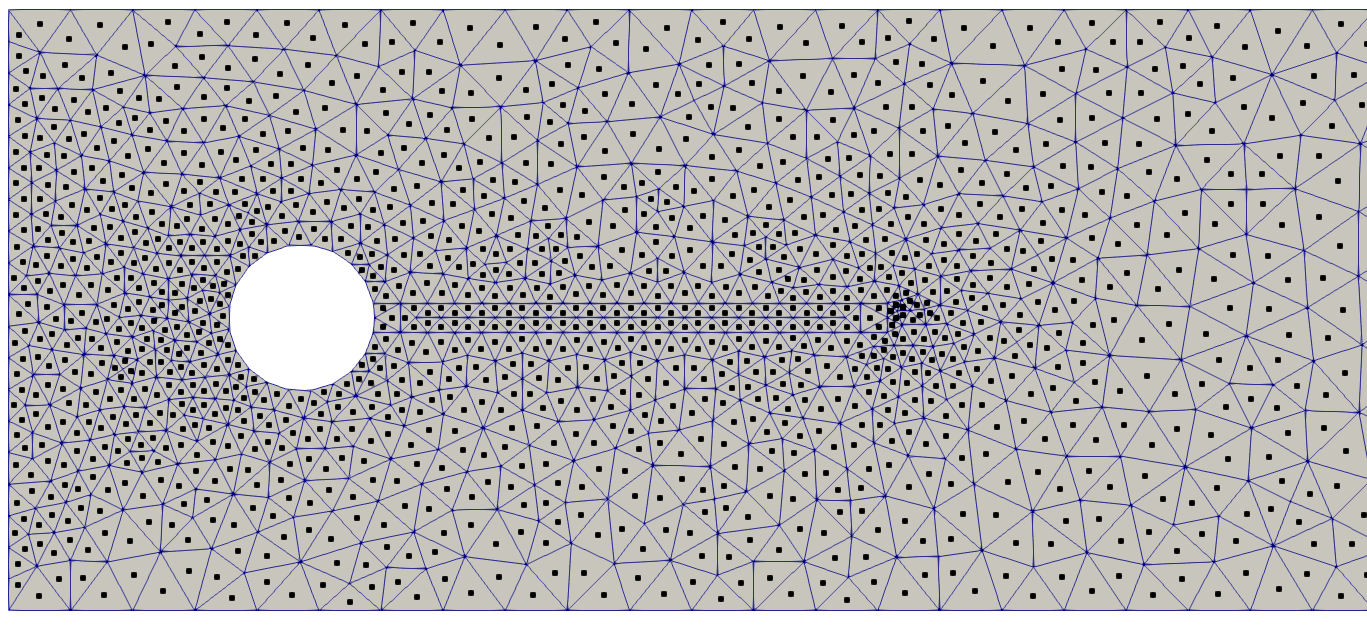
</div>


## Function evaluation

In [17]:
f(x) = sin(5*x[1])*cos(10*x[2])

f (generic function with 1 method)

In [18]:
cell_f = map(f,cell_barycenter)

2231-element Vector{Float64}:
 -0.06297394224072628
 -0.3095502351880181
 -0.22296225640028916
  0.9702430368762854
  0.9627160791208953
  0.35991856324735055
  0.2917401921042437
 -0.7970364585792342
 -0.025048569000481483
  0.08420149635830602
 -0.016153487222527123
 -0.7241762773978906
 -0.10109819497771629
  ⋮
 -0.21882867328695343
 -0.25322314781251376
 -0.29734358133487787
 -0.344078664447823
 -0.42346234786731113
 -0.36594483786842336
 -0.060832871595674944
 -0.0816137738176852
 -0.4554683403173239
 -0.3394947417125214
 -0.40188245977113873
 -0.08396946782069933

In [19]:
writevtk(cell_barycenter,"barycenters",nodaldata=["f"=>cell_f])

(["barycenters.vtu"],)

<div>
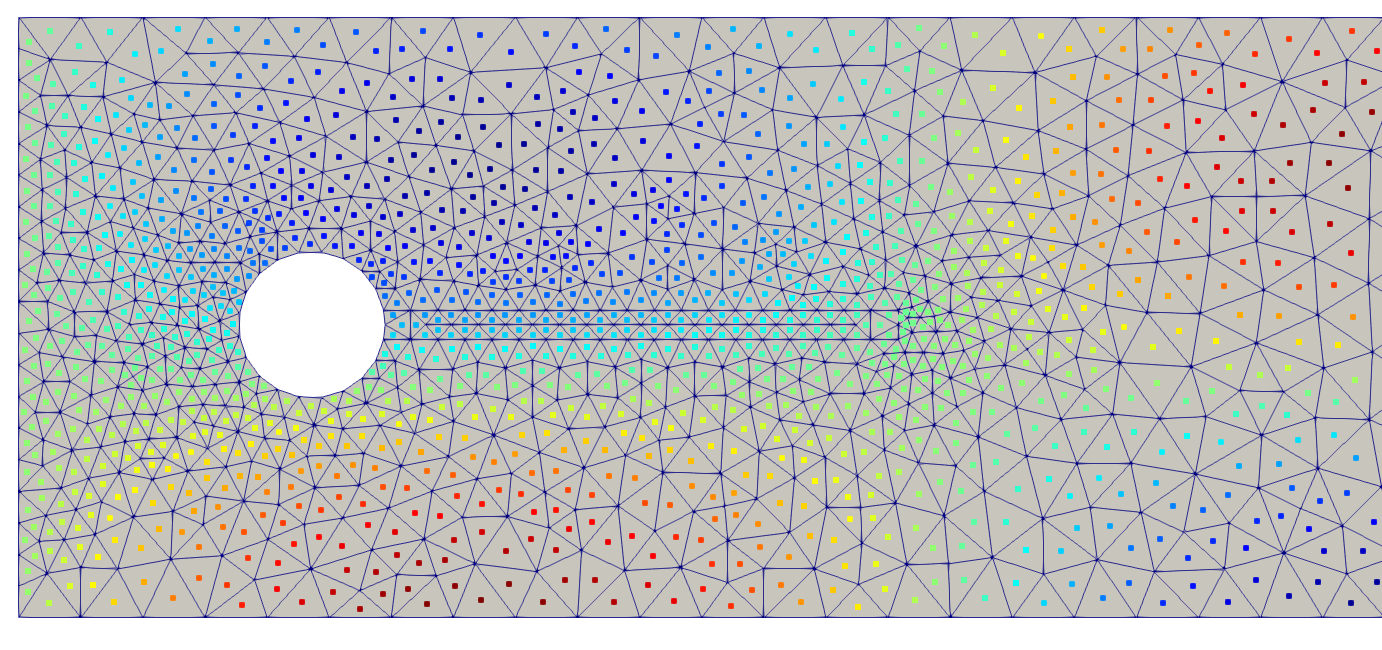
</div>


## Is this efficient?

In [20]:
sizeof(cell_barycenter)

35696

In [21]:
sizeof(cell_f)

17848

##  Solution: lazy_map

In [22]:
a = [1,2,3,4]
b = [5,6,7,8]
c = map(+,a,b)

4-element Vector{Int64}:
  6
  8
 10
 12

In [23]:
c_lazy = lazy_map(+,a,b)

4-element Gridap.Arrays.LazyArray{FillArrays.Fill{typeof(+), 1, Tuple{Base.OneTo{Int64}}}, Int64, 1, Tuple{Vector{Int64}, Vector{Int64}}}:
  6
  8
 10
 12

In [24]:
c[2] # Load item

8

In [25]:
c_lazy[2] # Compute item on the fly

8

## Operation tree

In [26]:
print_op_tree(c_lazy)

LazyArray
├─ Fill
│  └─ typeof(+)
├─ Vector{Int64}
└─ Vector{Int64}


## Use lazy_map in the example before

In [27]:
cell_barycenter = lazy_map(midpoint,cell_coords)
print_op_tree(cell_barycenter)

LazyArray
├─ Fill
│  └─ typeof(midpoint)
└─ LazyArray
   ├─ Fill
   │  └─ Broadcasting{Reindex{Vector{VectorValue{2, Float64}}}}
   └─ Table
      ├─ Vector{Int32}
      └─ Vector{Int32}


In [28]:
cell_f = lazy_map(f,cell_barycenter)
print_op_tree(cell_f)

LazyArray
├─ Fill
│  └─ typeof(f)
└─ LazyArray
   ├─ Fill
   │  └─ typeof(midpoint)
   └─ LazyArray
      ├─ Fill
      │  └─ Broadcasting{Reindex{Vector{VectorValue{2, Float64}}}}
      └─ Table
         ├─ Vector{Int32}
         └─ Vector{Int32}


In [29]:
writevtk(cell_barycenter,"barycenters_lazy",nodaldata=["f"=>cell_f])

(["barycenters_lazy.vtu"],)

## Bonus example

In [30]:
cell_coords = get_cell_coordinates(Γ)
cell_barycenter = lazy_map(midpoint,cell_coords)
cell_f = lazy_map(f,cell_barycenter)
writevtk(cell_barycenter,"barycenters_boundary",nodaldata=["f"=>cell_f])

(["barycenters_boundary.vtu"],)


<div>
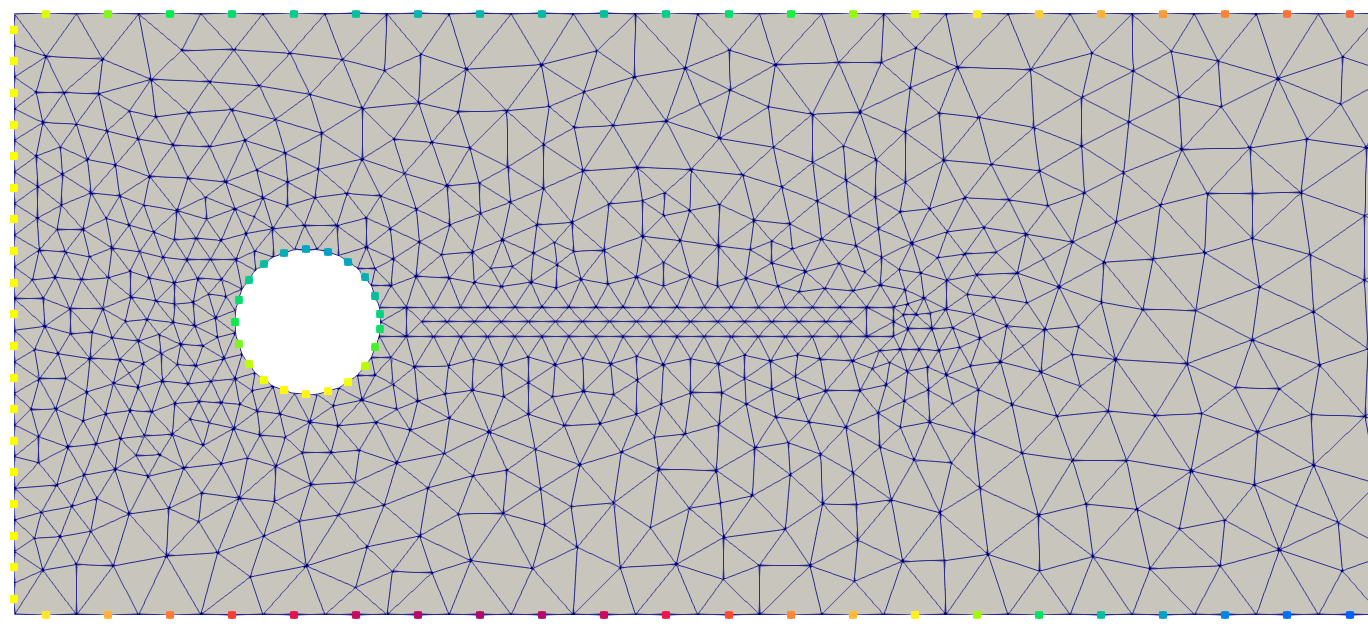
</div>
